# Adviewers Classification

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

### Create DataFrame

In [2]:
np.random.seed(42)
n = 10000

age = np.random.randint(18, 60, size=n)
gender = np.random.choice([0, 1], size=n)
estimated_salary = np.random.normal(50_000_000, 30_000_000, size=n).clip(5_000_000, 200_000_000)
time_on_page = np.random.normal(60, 30, size=n).clip(5, 300) 
ads_viewed = np.random.poisson(4, size=n).clip(0, 20)
clicked_ad = np.random.binomial(1, p=ads_viewed/20) 
registered = np.random.binomial(1, p=(clicked_ad * 0.7 + 0.2))


purchase_prob = (
    0.2 * (clicked_ad) +
    0.3 * (registered) +
    0.1 * (time_on_page > 60).astype(int) +
    0.1 * (ads_viewed > 5).astype(int) +
    0.05 * (estimated_salary > 50_000_000).astype(int)
)
purchase_prob = np.clip(purchase_prob, 0, 1)
purchased = np.random.binomial(1, p=purchase_prob)


df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'EstimatedSalary': estimated_salary.astype(int),
    'TimeOnPage': time_on_page.round(1),
    'AdsViewed': ads_viewed,
    'ClickedAd': clicked_ad,
    'Registered': registered,
    'Purchased': purchased
})


df.loc[df.sample(frac=0.05).index, 'Age'] = np.nan
df.loc[df.sample(frac=0.03).index, 'EstimatedSalary'] = np.nan
df.loc[df.sample(frac=0.02).index, 'Gender'] = np.nan


df

,Age,Gender,EstimatedSalary,TimeOnPage,AdsViewed,ClickedAd,Registered,Purchased
0,56.0,NaN,20500770.0,23.0,7,0,1,1
1,46.0,1.0,14677985.0,47.7,4,0,0,0
2,32.0,0.0,5000000.0,27.3,6,0,0,0
3,25.0,0.0,64410100.0,96.6,2,0,0,0
4,38.0,1.0,60237439.0,24.5,2,0,0,0
...,...,...,...,...,...,...,...,...
9995,26.0,0.0,25705530.0,63.7,3,0,0,0
9996,58.0,0.0,89548883.0,72.4,3,0,0,0
9997,35.0,0.0,72909302.0,143.7,5,0,0,0
9998,46.0,0.0,19871790.0,41.3,5,1,1,1


### Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              9500 non-null   float64
 1   Gender           9800 non-null   float64
 2   EstimatedSalary  9700 non-null   float64
 3   TimeOnPage       10000 non-null  float64
 4   AdsViewed        10000 non-null  int32  
 5   ClickedAd        10000 non-null  int32  
 6   Registered       10000 non-null  int32  
 7   Purchased        10000 non-null  int32  
dtypes: float64(4), int32(4)
memory usage: 468.9 KB


In [4]:
print(df.isnull().mean()*100)

Age                5.0
Gender             2.0
EstimatedSalary    3.0
TimeOnPage         0.0
AdsViewed          0.0
ClickedAd          0.0
Registered         0.0
Purchased          0.0
dtype: float64


In [5]:
df.dropna(inplace=True)

In [6]:
df.describe()

,Age,Gender,EstimatedSalary,TimeOnPage,AdsViewed,ClickedAd,Registered,Purchased
count,9028.000000,9028.000000,9.028000e+03,9028.000000,9028.000000,9028.000000,9028.000000,9028.000000
mean,38.534005,0.503434,5.070045e+07,60.449324,4.043310,0.196057,0.338059,0.241471
std,12.000667,0.500016,2.803120e+07,29.425345,2.014846,0.397034,0.473075,0.427999
min,18.000000,0.000000,5.000000e+06,5.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,2.951363e+07,39.600000,3.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,4.970137e+07,60.100000,4.000000,0.000000,0.000000,0.000000
75%,49.000000,1.000000,6.995431e+07,80.600000,5.000000,0.000000,1.000000,0.000000
max,59.000000,1.000000,1.495306e+08,178.200000,13.000000,1.000000,1.000000,1.000000


In [7]:
df['Clicked&Registed'] = df['ClickedAd'] & df['Registered']
df['AdPerMin'] = df['AdsViewed'] / df['TimeOnPage']

df['AgeGroup'] = pd.cut(df['Age'],bins=[17,25,35,50,100],labels=['Young','Adult','Middle-aged','Elderly'])
df['SalaryRange'] = pd.cut(df['EstimatedSalary'],bins=[0,20000000,50000000,100000000,np.inf],labels=['Low','Middle','High','Very High'])
df['EngagementScore'] = df['TimeOnPage'] * (df['ClickedAd'] + 1) * (df['Registered'] + 1)

categorical = ['Gender','ClickedAd','Registered','Clicked&Registed','AgeGroup','SalaryRange']

for c in categorical:
    df[c] = df[c].astype('category')

df['Purchased'] = df['Purchased'].astype('category')

df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})

for c in ['ClickedAd','Registered','Clicked&Registed']:
    df[c] = df[c].map({0:'No',1:'Yes'})


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9028 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               9028 non-null   float64 
 1   Gender            9028 non-null   category
 2   EstimatedSalary   9028 non-null   float64 
 3   TimeOnPage        9028 non-null   float64 
 4   AdsViewed         9028 non-null   int32   
 5   ClickedAd         9028 non-null   category
 6   Registered        9028 non-null   category
 7   Purchased         9028 non-null   category
 8   Clicked&Registed  9028 non-null   category
 9   AdPerMin          9028 non-null   float64 
 10  AgeGroup          9028 non-null   category
 11  SalaryRange       9028 non-null   category
 12  EngagementScore   9028 non-null   float64 
dtypes: category(7), float64(5), int32(1)
memory usage: 521.1 KB


In [9]:
numerical = ['Age','EstimatedSalary','TimeOnPage','AdsViewed','AdPerMin','EngagementScore']

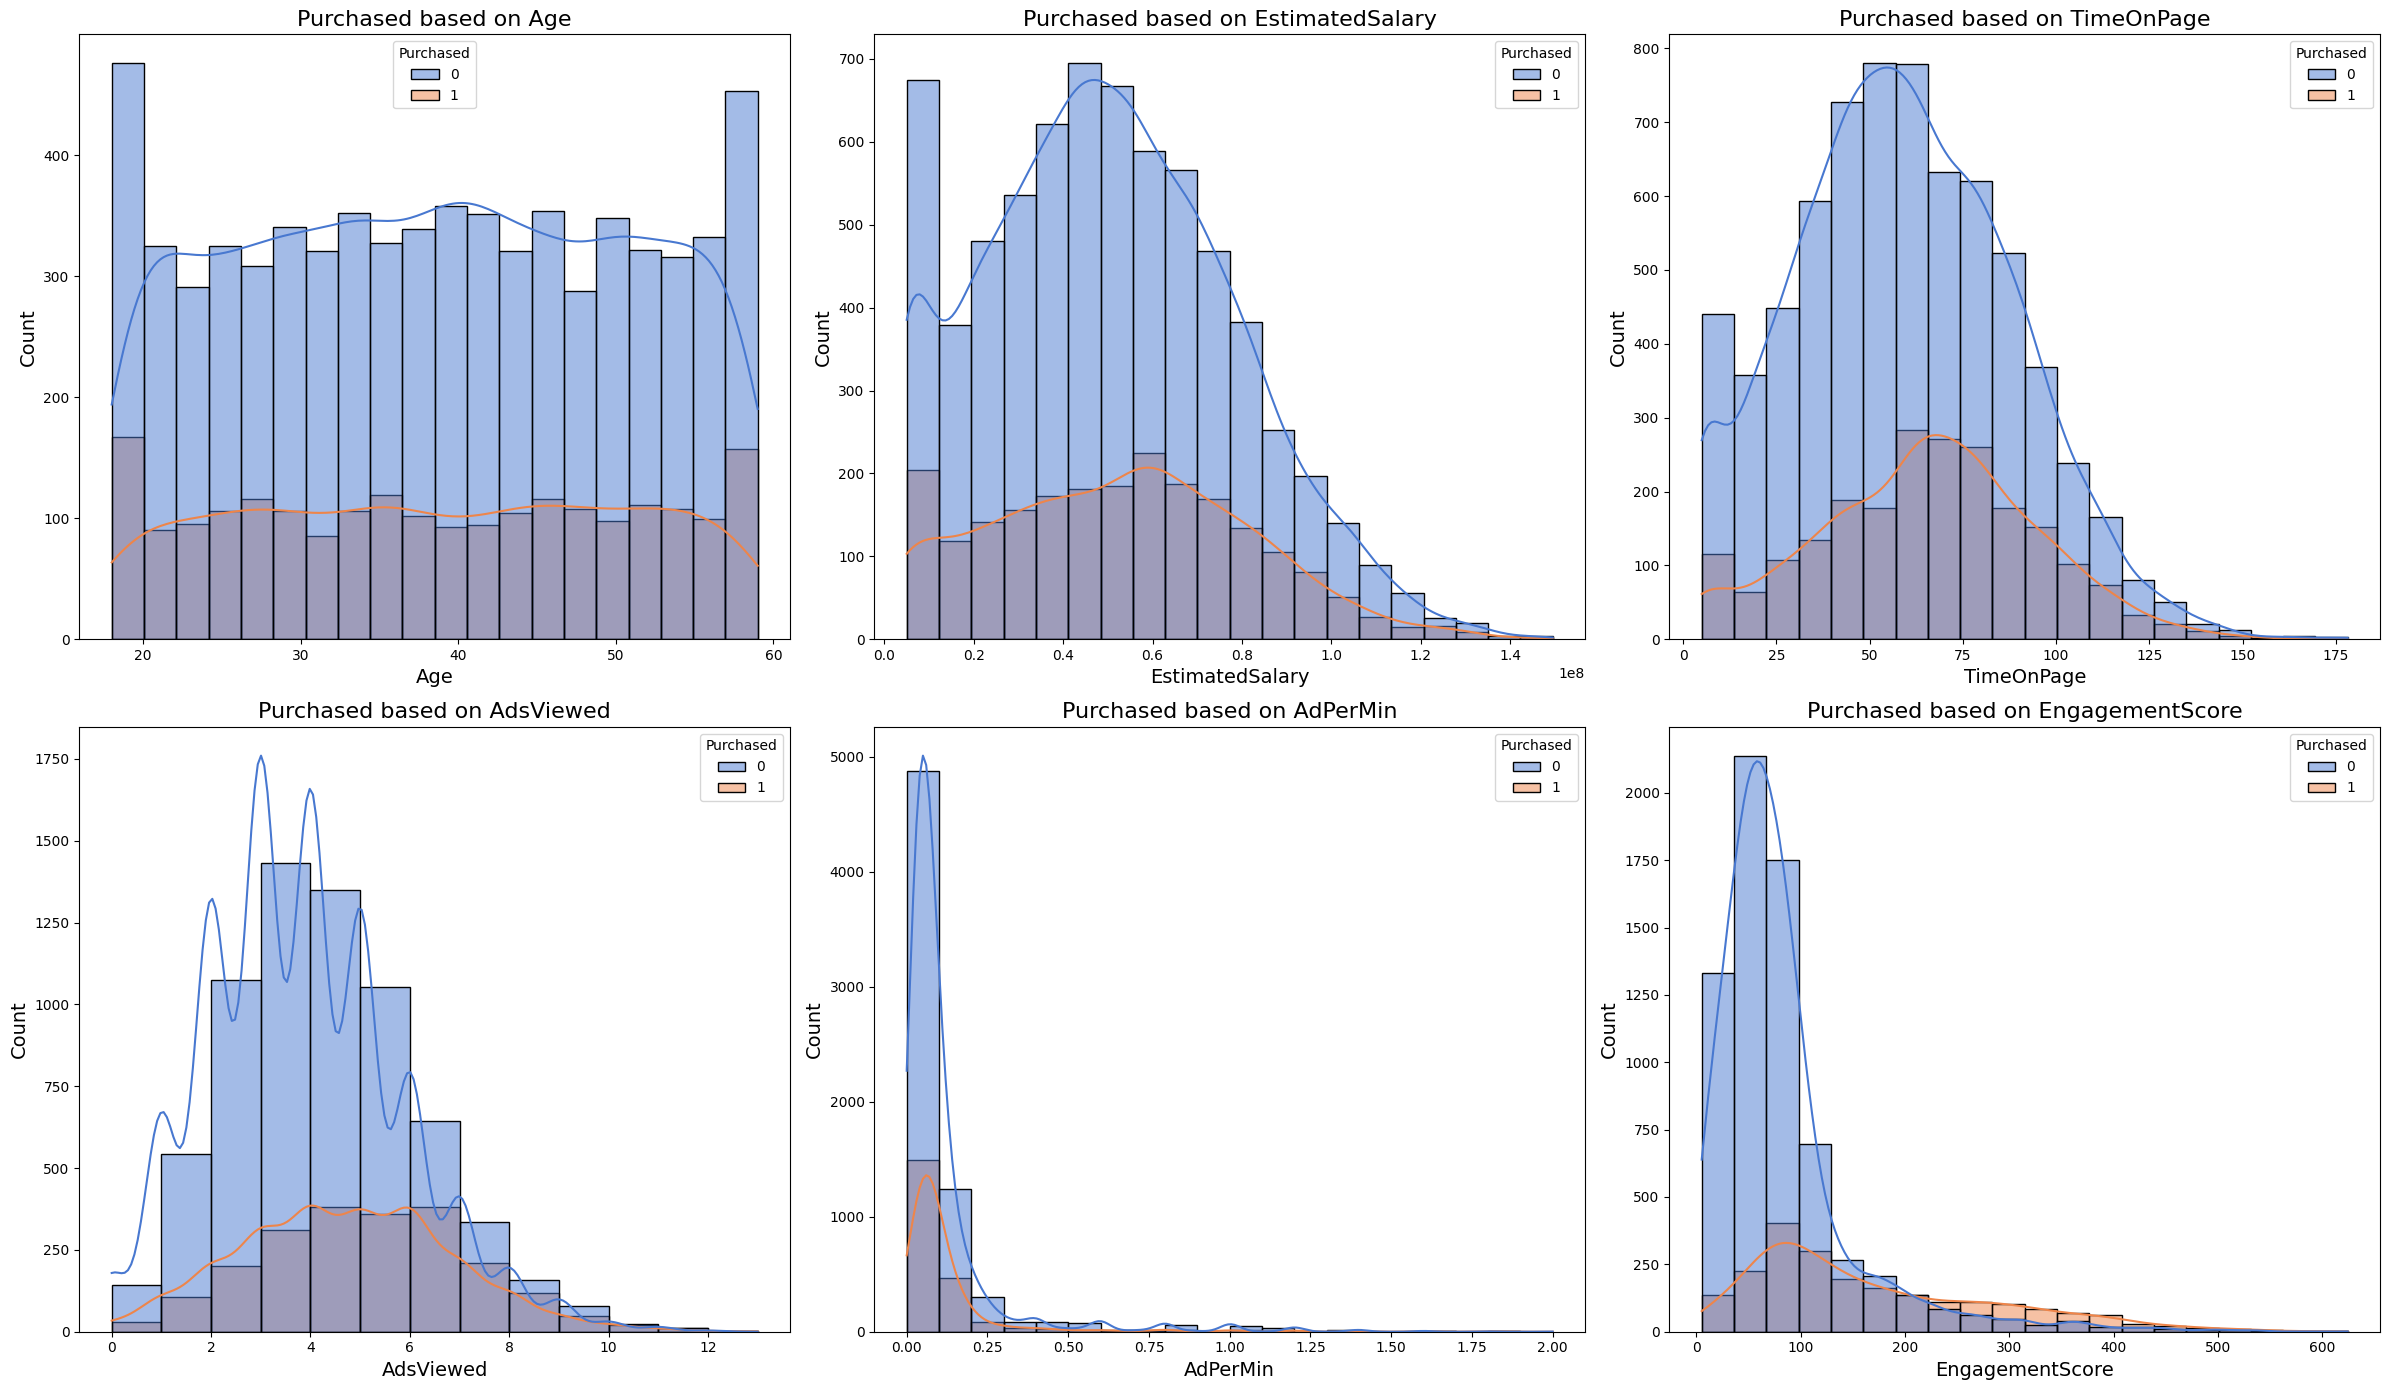

In [10]:
num_stats ={}
fig, axes = plt.subplots(2,3,figsize=(24,14))
for r in range(2):
    for c in range(3):
        col = numerical[r*3 + c]
        fea = df[col]
        sk = skew(fea)
        kur = kurtosis(fea)
        num_stats[col] = sk,kur
        bins = 20
        if col == 'AdsViewed': bins = 13
        sns.histplot(df,x=fea,kde= True,bins=bins,hue='Purchased',palette='muted',ax=axes[r,c])
        axes[r,c].set_title(f'Purchased based on {col}',fontsize=16)
        axes[r,c].set_xlabel(f'{col}',fontsize=14)
        axes[r,c].set_ylabel('Count',fontsize=14)
plt.tight_layout()        
plt.show()

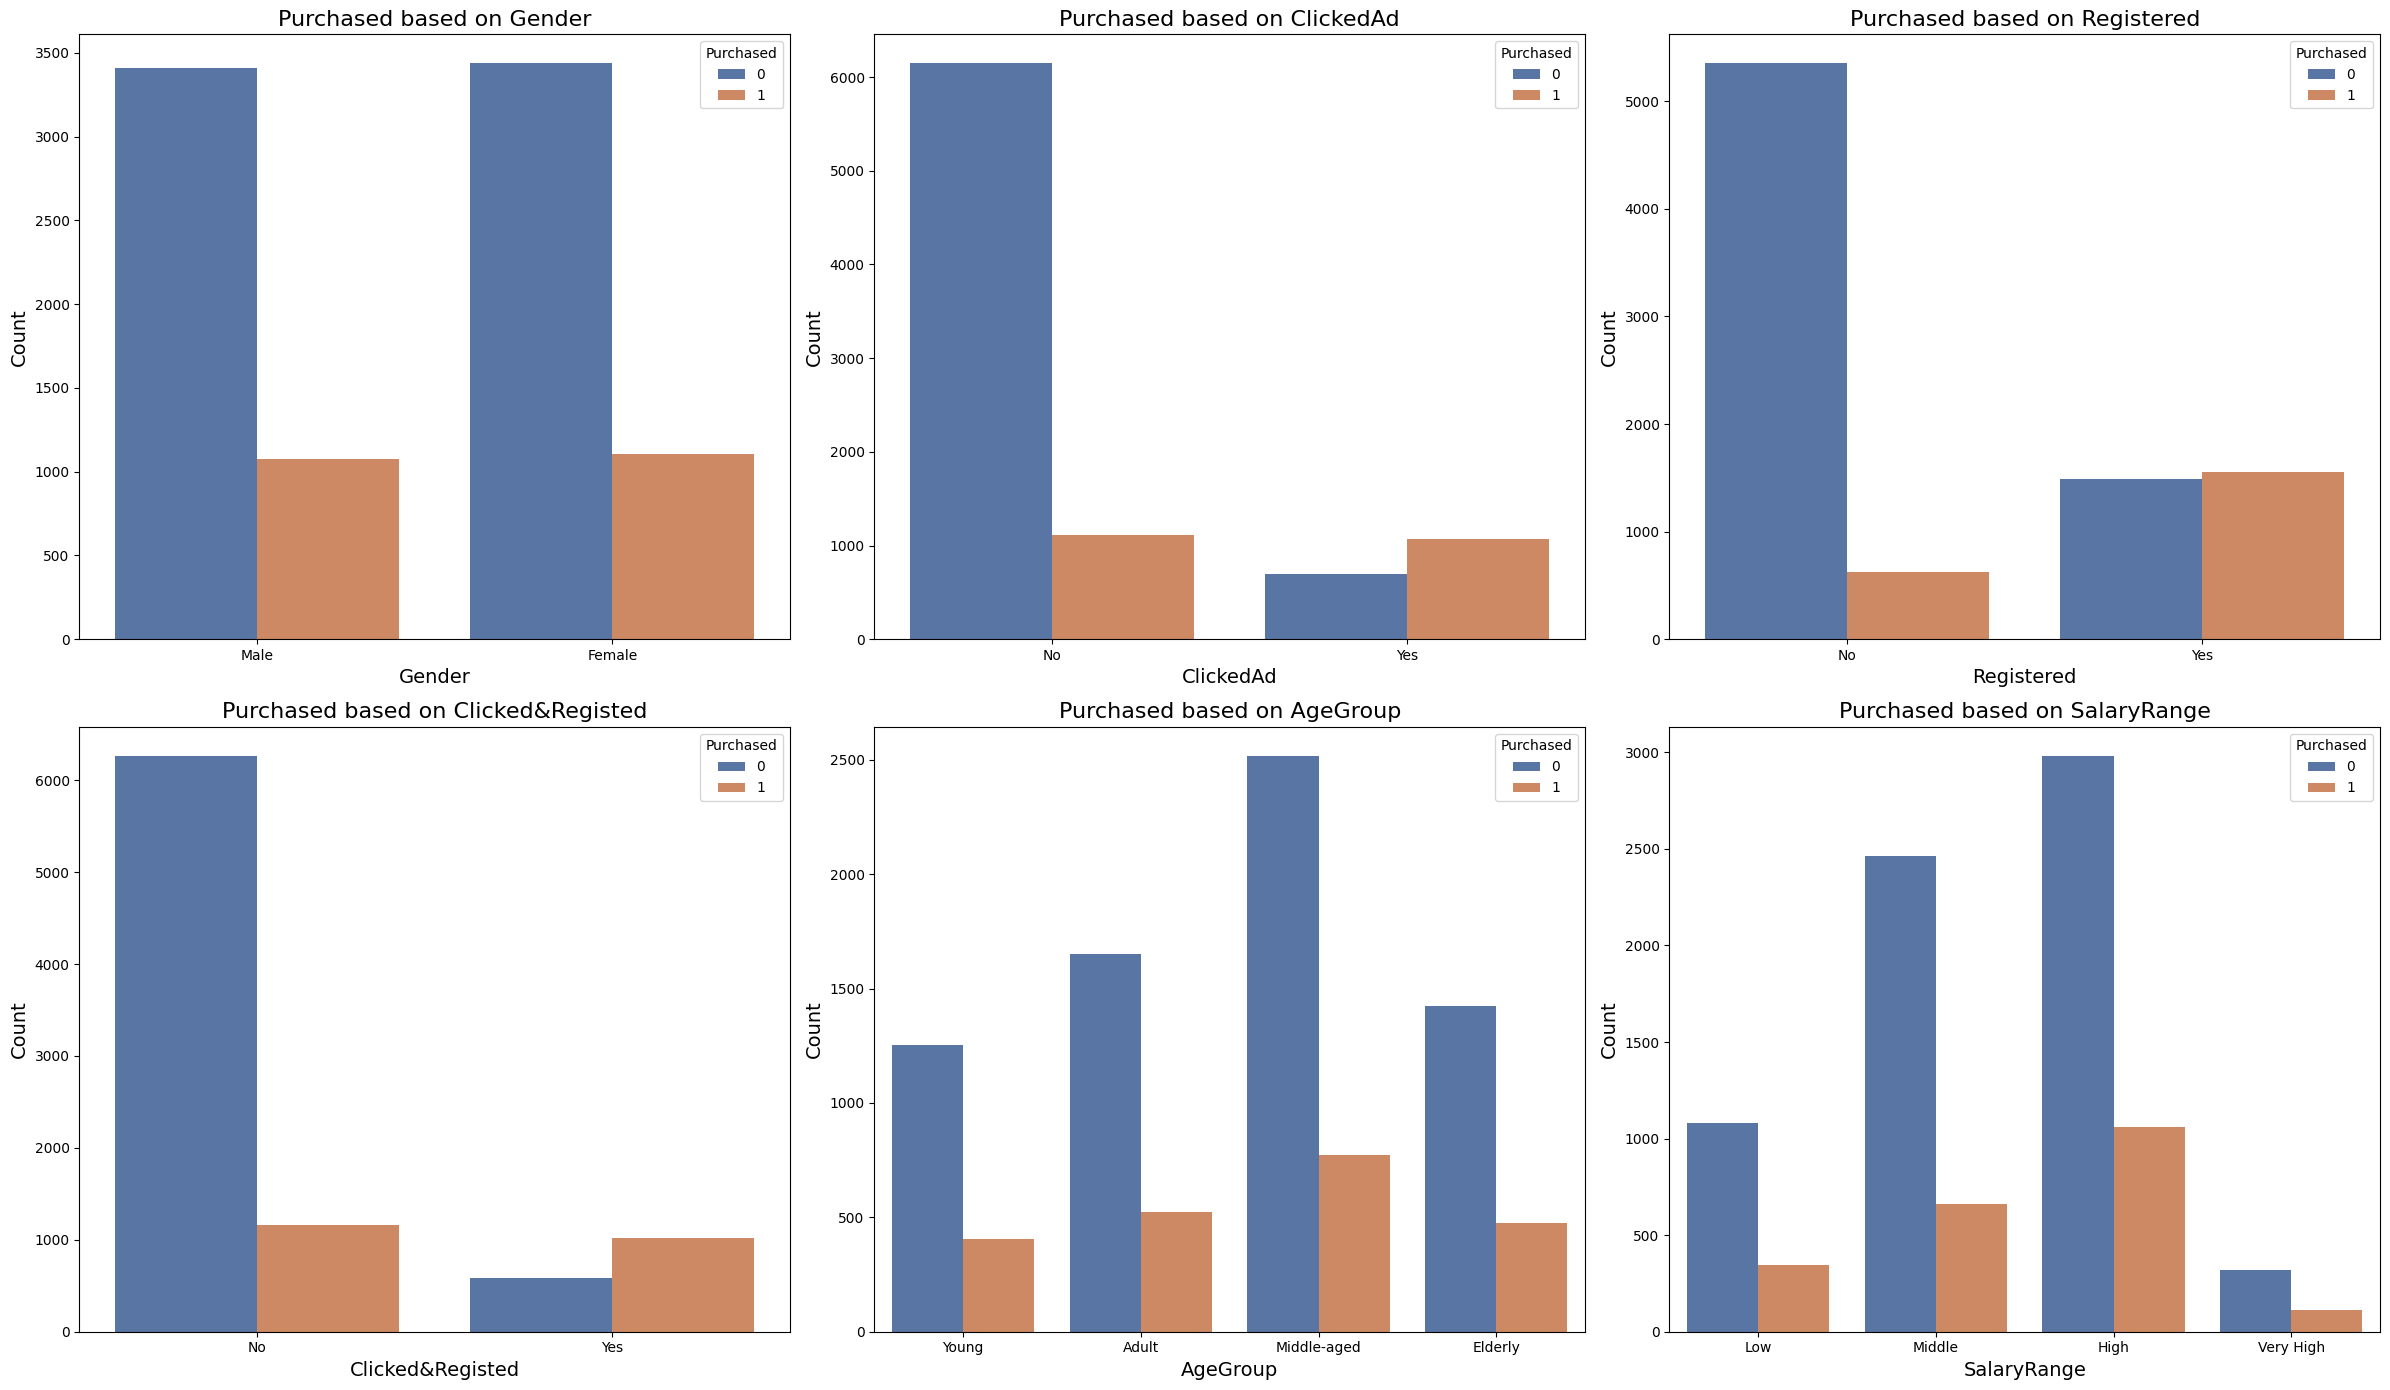

In [11]:
fig, axes = plt.subplots(2,3,figsize=(24,14))
for r in range(2):
    for c in range(3):
        col = categorical[r*3 + c]
        fea = df[col]
        sns.countplot(data=df,x=fea,hue='Purchased',palette='deep',ax=axes[r,c])
        axes[r,c].set_title(f'Purchased based on {col}',fontsize=16)
        axes[r,c].set_xlabel(f'{col}',fontsize=14)
        axes[r,c].set_ylabel('Count',fontsize=14)
plt.tight_layout()        
plt.show()
    

In [12]:
def remove_outliers(df,fea):
    Q1 = df[fea].quantile(0.25)
    Q3 = df[fea].quantile(0.75)
    IRQ = Q3 - Q1

    lb = Q1 - 1.5*IRQ
    ub = Q3 + 1.5*IRQ

    filtered_df = df[(df[fea]>=lb) & (df[fea]<=ub)]
    return filtered_df

for fea in numerical:
    sk, kur = num_stats[fea]
    abs_sk = abs(sk)
    
    if abs_sk > 5:
        df[fea] =  np.log1p(df[fea])
    elif abs_sk > 3:
        df[fea] =  (df[fea])**0.3
    elif abs_sk > 1:
        df.loc[:, fea] = np.sqrt(df[fea])

    if kur > 5:
        df = remove_outliers(df,fea)
    elif kur <-5:
        df[fea] = StandardScaler().fit_transform(df[fea])

In [13]:
class LogisticRegression:
    def __init__(self, learningrate=0.01, epochs=1000):
        self.lr = learningrate
        self.epochs = epochs
        self.w = None
        self.b = None
        self.loss_list = []

    def initial(self, n_features: int):
        self.w = np.zeros(n_features)
        self.b = 0

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def get_loss_list(self):
        return self.loss_list

    def fit(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)

        if X.ndim == 1:
            X.resize(-1, 1)

        len_val, len_fea = X.shape
        self.initial(len_fea)
        for epoch in range(self.epochs):

            Y_hat = np.clip(
                self.sigmoid(np.dot(X, self.w) + self.b), 1e-15, 1 - 1e-15
            )
            cross_entropy = -np.mean(
                Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)
            )
            self.loss_list.append(cross_entropy)

            dw = np.dot(X.T, (Y_hat - Y)) / len_val
            db = np.sum(Y_hat - Y) / len_val

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X, threshold=0.5):
        X = np.array(X)
        Z = np.dot(X, self.w) + self.b
        Y_pred = self.sigmoid(Z)
        return [1 if y_pred >= threshold else 0 for y_pred in Y_pred]
    
    def predict_prob(self,X):
        X = np.array(X)
        Z = np.dot(X, self.w) + self.b
        return self.sigmoid(Z)


    def get_params(self):
        return self.w, self.b

In [14]:
X = df.drop(columns=['Purchased'])
y = df['Purchased']
print(pd.Series(y).value_counts())

Purchased
0    6318
1    2032
Name: count, dtype: int64


In [15]:
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore',drop='first')
X_cat = encoder.fit_transform(X[categorical])
X_num = X[numerical]
X = np.hstack([X_num, X_cat])


In [16]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
from imblearn.over_sampling import SMOTE # balance the data
smote = SMOTE(sampling_strategy='minority')
X_train_scaled, y_train_scaled = smote.fit_resample(X_train_scaled,y_train)

In [17]:
logR_model = LogisticRegression(epochs=3000)
logR_model.fit(X_train_scaled,y_train_scaled)

In [18]:
y_pred = logR_model.predict(X_val_scaled)
print(f'Accuracy: {accuracy_score(y_val,y_pred)}')
print(classification_report(y_val,y_pred,zero_division=0))


Accuracy: 0.7802395209580838
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1263
           1       0.54      0.69      0.60       407

    accuracy                           0.78      1670
   macro avg       0.71      0.75      0.73      1670
weighted avg       0.80      0.78      0.79      1670



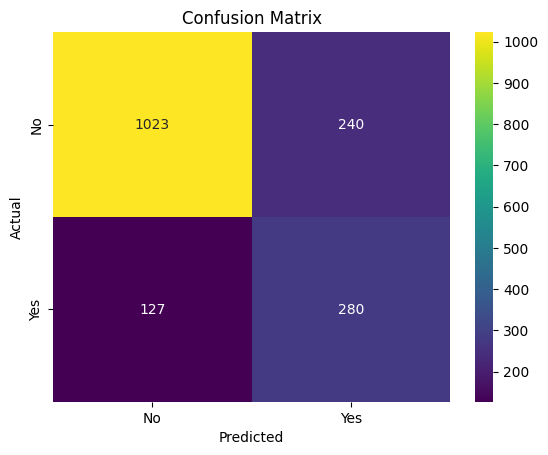

In [19]:
cm = confusion_matrix(y_val,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='viridis',xticklabels=['No','Yes'],yticklabels=['No','Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

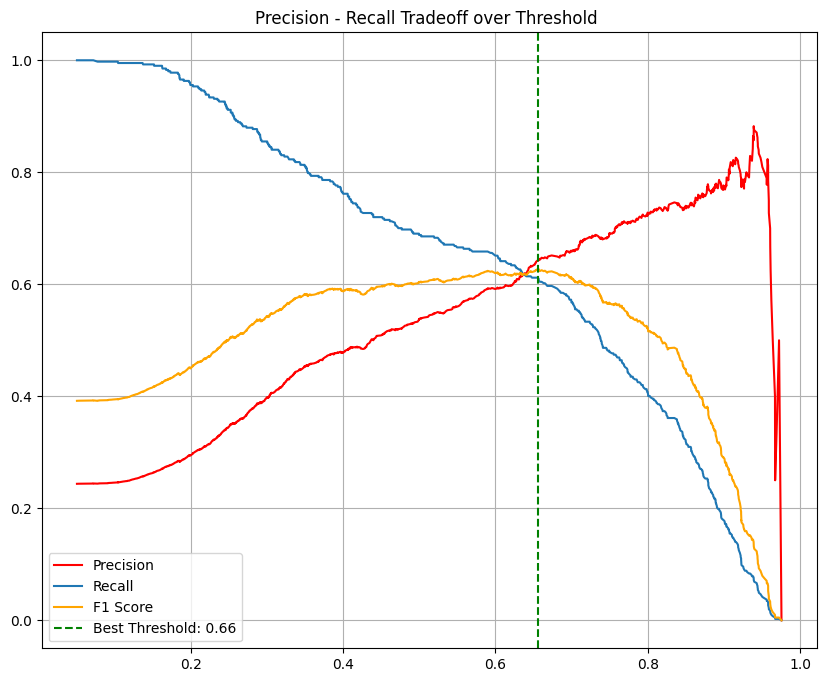

In [20]:
y_prob = logR_model.predict_prob(X_val_scaled)
precisions,recalls,thresholds =  precision_recall_curve(y_val,y_prob)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-20)

best_threshold = thresholds[f1s.argmax()]

plt.figure(figsize=(10,8))
plt.plot(thresholds,precisions[:-1],c='red',label = 'Precision')
plt.plot(thresholds,recalls[:-1],label= 'Recall')
plt.plot(thresholds,f1s[:-1],label = 'F1 Score', c='orange')
plt.axvline(x=best_threshold,c='green',linestyle='--',label=f'Best Threshold: {best_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.title('Precision - Recall Tradeoff over Threshold ')
plt.show()


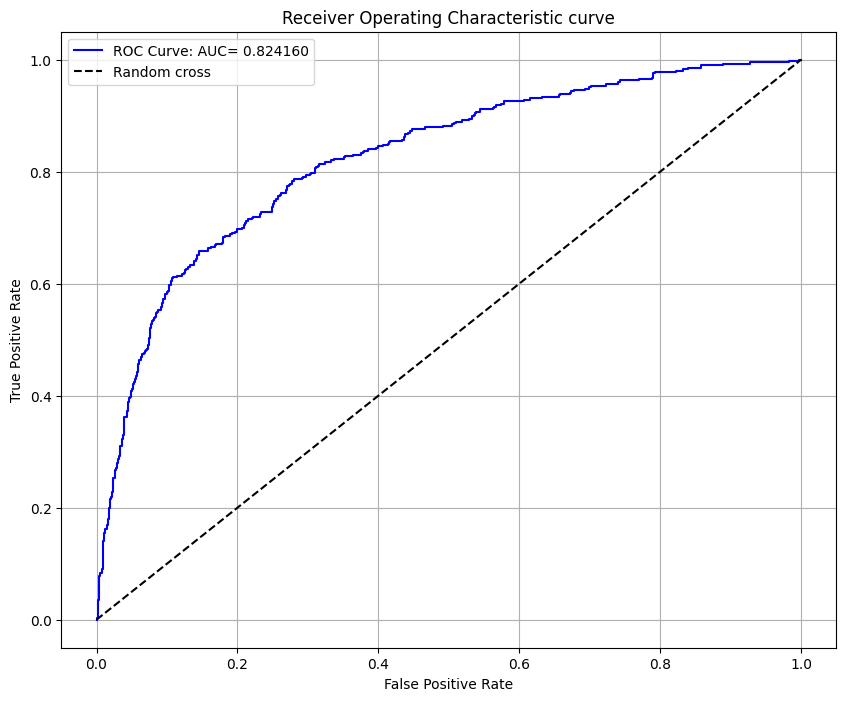

In [21]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob)

auc_score = roc_auc_score(y_val, y_prob)


plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='blue',label=f'ROC Curve: AUC= {auc_score:2f}')
plt.plot([0,1],[0,1],linestyle='--',label='Random cross',c='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend()
plt.grid(True)
plt.show()